In [ ]:
import matplotlib as mpl
# mpl.use('TkAgg')

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons, TextBox
import tkinter as tk
from tkinter import filedialog
import re
import ipywidgets as widgets
from IPython.display import display

# %matplotlib inline
%matplotlib qt
#bug: if I start with inline then change it to qt it's fine...otherwise error if starting qt

In [128]:
viewer('/Users/michaelstadler/Bioinformatics/Projects/hic/viewerfiles/hic-66-68', '/Users/michaelstadler/Bioinformatics/Projects/hic/viewerfiles/viewer_tracks', '')

interactive(children=(Dropdown(description='Color', index=6, options=('viridis', 'Reds', 'plasma', 'gray_r', '…

['S5_DNase_rep1_', 'Dmel-H3K27me3-c14c', 'Dmel-H3K27ac-c14c', 'S5_polII_FDR25', 'CP190_0_12h', 'BEAF-32_0_12h', 'dCTCF_0_12h', 'dm6_promoters']
S5_DNase_rep1_


GridspecLayout(children=(Dropdown(description='Chrom', layout=Layout(grid_area='widget001'), options=('X', '3R…

<IPython.core.display.Javascript object>


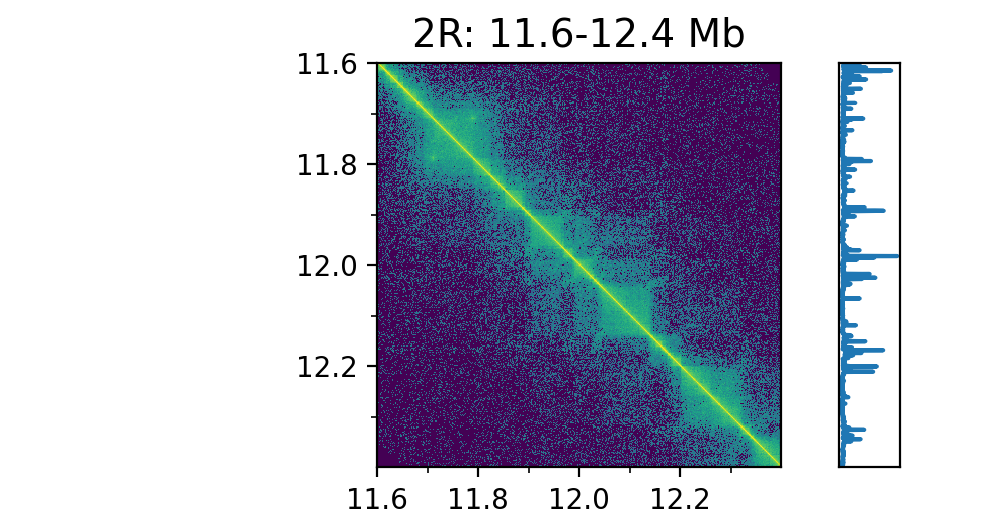

In [400]:
# Latest viewer.
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, IntSlider, Dropdown, IntRangeSlider, fixed, RadioButtons, IntText, Button, Layout, ToggleButton
from ipywidgets import GridspecLayout
from IPython.display import display, clear_output
import re
%matplotlib notebook
%matplotlib notebook


def viewer(data_folder, track_folder, save_folder):
    """Jupyter notebook viewer for Hi-C data
    
    Args:
        data_folder: string or file object
            Folder containing Hi-C viewer files
        track_folder: string or file object
            Folder containing genomic track data
        save_folder: string or file object
            Folder to save images to.
            
    Returns: None
        
    """
    
    class State:
        """State objects store the state of the viewer."""
        def __init__(self):
            self.chr = ""
            self.binsize = 2000
            self.posL = 0
            self.cmap = "viridis"
            self.step_size = 100000
            self.window_size = 200000
            self.track_data = {}
            self.posR = 10800000
            self.track_files = set()
            self.track_data = {}
            self.chr_maxes = {}
    
    ############################################################################
    # General functions
    ############################################################################
    
    def get_chr_maxes(data_folder):
        """Find the maximum location (size) of each chromosome from files in the 
        viewer data folder, return dict with chromosomes as keys and size as 
        values."""
        chr_maxes = {}
        for filename in os.listdir(data_folder):
            chr_, pos1, pos2, binsizetxt = filename.split('_')
            max_ = int(pos1)
            if (chr_ not in chr_maxes):
                chr_maxes[chr_] = max_
            elif (max_ > chr_maxes[chr_]):
                chr_maxes[chr_] = max_
        return chr_maxes
    
    def combine_colormaps(cm1, cm2):
        """Combine two mpl colormaps."""
        colors1 = cm1(np.linspace(0., 1, 128))
        colors2 = cm2(np.linspace(0, 1, 128))
        colors = np.vstack((colors1, colors2))
        return(mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors))
    
    def load_viewer_file(infilename):
        """Load viewer file of a Hi-C matrix, replace 0s and NaNs with dummy values, 
        trim outliers, take log."""
        # Load data, remove row names in first column.
        x = np.genfromtxt(infilename, delimiter='\t', skip_header=1)[:,1:]
        # Resolve 0s and NaNs by setting to dummy value 0.1.
        dummy_val = 0.1
        x[x == 0] = dummy_val
        x[np.isnan(x)] = dummy_val
        # Remove large outlier values using a percentile cutoff.
        upper_trim = 99.9
        max_val = np.percentile(x, upper_trim)
        x[x > max_val] = max_val
        # Take the log.
        x = np.log(x)
        # Scale to a range of 0-1000.
        x = (x - np.min(x)) / (np.max(x) - np.min(x)) * 1000
        return(x)
    
    def load_track_data(trackfile_path):
        """Load genomic track data."""
        track_binsize = 500
        track_data = {}
        with open(trackfile_path, 'r') as infile:
            for line in infile:
                items = line.split()
                (chr_, posL, posR, val) = items
                chr_ = re.sub('chr', '', chr_)
                if (chr_ in state.chr_maxes):
                    if (chr_ not in track_data):
                        max_bin = int(state.chr_maxes[chr_] / track_binsize)
                        track_data[chr_] = np.zeros(max_bin + 1000)
                    track_bin = int(int(posL) / track_binsize)
                    track_data[chr_][track_bin] = float(val)
        return track_data
    
    def get_track_files(track_folder):
        """Find all files in the track files folder, return set of file names."""
        track_files = []
        for filename in os.listdir(track_folder):
            base = filename.split('.')[0]
            track_files.append(base)
        return track_files[1:] # Remove hidden macOS file.
    
    def update_position():
        """When a new position is specified by a change in chromosome, position, or 
        resolution, load the new file and draw the figure."""
        state.posR = state.posL + (state.binsize * 400)
        file = os.path.join(data_folder, state.chr + '_' + str(state.posL) + '_' + str(state.posR) + '_' + str(state.binsize) + '.txt')
        if (os.path.isfile(file) or os.path.isfile(file + '.gz')): 
            # Load and draw Hi-C portion of figure.
            new_img = load_viewer_file(file)
            img.set_data(new_img)
            L_Mb = float(state.posL) / 1e6
            R_Mb = float(state.posR) / 1e6
            img.set_extent([L_Mb, R_Mb, R_Mb, L_Mb])
            ax[0].set_title(state.chr + ': ' + str(L_Mb) + '-' + str(R_Mb) + ' Mb', fontsize=14)
            minorticks = np.arange(L_Mb, R_Mb, (R_Mb - L_Mb) / 8)
            majorticks = np.arange(L_Mb, R_Mb, (R_Mb - L_Mb) / 4)
            ax[0].set_xticks(majorticks)
            ax[0].set_yticks(majorticks)
            ax[0].set_xticks(minorticks, minor=True)
            ax[0].set_yticks(minorticks, minor=True)

            # Draw genomic track portion of figure.
            track_binsize = 500
            track_binL = int(state.posL / track_binsize)
            track_binR = int(state.posR / track_binsize)
            ax[1].cla()
            ax[1].plot(state.track_data[state.chr][np.arange(track_binR, track_binL, -1)], np.arange(track_binL, track_binR))
            ax[1].set_ylim(track_binL, track_binR)
            ax[1].set_yticklabels([])
            ax[1].set_xticklabels([])
            ax[1].set_xticks([])
            ax[1].set_yticks([])
            
            # Execute changes on screen.
            fig.canvas.draw_idle()
            
        else:
            ax[0].set_title('Position is out of bounds!', fontsize=14)

    ############################################################################
    # Widgets
    ############################################################################
    
    # Dropdown to select colormap. 
    def make_cmap_dropdown():
        cmap_dropdown = Dropdown(
            options={'BlOr', 'Greens', 'Reds', 'viridis', 'plasma', 'magma', 'inferno','cividis', 
            'gray', 'gray_r', 'RdGy_r'},
            value='viridis',
            description='Color',
        )
        cmap_dropdown.observe(cmap_dropdown_onchange, names="value")
        return cmap_dropdown
    
    def cmap_dropdown_onchange(change):
        selection = change['new']
        if (selection == 'BlOr'):
            cmap = combine_colormaps(plt.cm.Blues_r, plt.cm.YlOrBr)
        else:
            cmap = selection
        state.cmap = cmap    
        img.set_cmap(cmap)
        fig.canvas.draw_idle()

    ############################################################################
    
    # Dropdown to change chromosome.
    def make_chr_dropdown(data_folder, chrs):
        chr_dropdown = Dropdown(
            options=chrs,
            description='Chrom',
        )
        chr_dropdown.observe(chr_dropdown_onchange, names="value")
        state.chr = list(chrs)[0]
        return chr_dropdown
    
    def chr_dropdown_onchange(change):
        new_chr = change['new']
        state.chr = new_chr
        pos_slider.max = state.chr_maxes[new_chr]
        update_position()
    
    ############################################################################
    
    # Dropdown to change resolution.
    def make_resolution_dropdown():
        res_dropdown = Dropdown(
            options=['500', '1000', '2000', '4000'],
            value='2000',
            description='Resolution',
        )
        res_dropdown.observe(res_dropdown_onchange, names="value")
        return res_dropdown
    
    def res_dropdown_onchange(change):
        res = change['new']
        state.binsize = int(res)
        pos_slider.step = state.binsize * 200
        state.posL = int(state.posL / (state.binsize * 200)) * state.binsize * 200
        update_position()

    ############################################################################
    
    # Dropdown to change genomic track.
    def make_track_dropdown(track_folder):
        track_dropdown = Dropdown(
            options=state.track_files,
            description='Track',
        )
        track_dropdown.observe(track_dropdown_onchange, names="value")
        print(state.track_files[0])
        first_track_file = os.path.join(track_folder, state.track_files[0] + '.txt')
        state.track_data = load_track_data(first_track_file)
        return track_dropdown
    
    def track_dropdown_onchange(change):
        new_track_base = change['new']
        track_filename = os.path.join(track_folder, new_track_base + '.txt')
        state.track_data = load_track_data(track_filename)
        update_position()
    
    ############################################################################

    # Range slider for adjusting image contrast.
    def make_constrast_slider():
        min_ = 0
        max_ = 1000
        contrast_slider = IntRangeSlider(
            value=[min_, max_],
            min=min_,
            max=max_,
            step=1,
            description='Contrast',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d',
            layout=Layout(height='auto', width='auto')
        )
        contrast_slider.observe(contrast_slider_onchange, names="value")
        return contrast_slider
    
    def contrast_slider_onchange(change):
        min_, max_ = change['new']
        img.set_norm(mpl.colors.Normalize(vmin=min_, vmax=max_))
        fig.canvas.draw_idle()

    ############################################################################

    # Int slider to select chromosomal position.
    def make_pos_slider():
        pos_slider = IntSlider(
                        value=0,
                        min=0,
                        max=3e7,
                        step=400000,
                        description='Pos:',
                        layout=Layout(height='auto', width='auto'),
                        continuous_update=False,
                        disabled=False
        )
        pos_slider.observe(pos_slider_onchange, names="value")
        return pos_slider
    
    def pos_slider_onchange(change):
        pos = change['new']
        new_pos = int(pos / (state.binsize * 200)) * state.binsize * 200
        state.posL = new_pos
        update_position()

    ############################################################################       
    
    # Toggle button to turn grid on and off.
    def make_grid_toggle():
        grid_toggle = ToggleButton(
            value=False,
            description='Grid',
            disabled=False,
            button_style='',
            tooltip='Grid',
        )
        grid_toggle.observe(grid_toggle_onchange, names="value")
        return grid_toggle
    
    def grid_toggle_onchange(change):
        status = change['new']
        if (status):
            col = "red"
            if (state.cmap in ['RdGy_r', 'Reds']):
                col = "blue"
            if (state.cmap in ['inferno', 'magma', 'cividis', 'plasma', 'viridis']):
                col = "white"
            ax[0].grid(which="both", color=col, alpha=0.4)
            fig.canvas.draw_idle()
        else:
            ax[0].grid(False, which="both")
            fig.canvas.draw_idle()
            
    ############################################################################       
    
    # Button to save figure.
    def make_save_button():
        save_button = Button(
            value=False,
            description='Save',
            disabled=False,
            button_style='',
            tooltip='Save figure',
        )
        save_button.on_click(save_button_onchange)
        return save_button
    
    def save_button_onchange(change):
        file_path = os.path.join(save_folder, (state.chr + '_' + str(state.posL) + '_' + str(state.posR) + '.png'))
        fig.savefig(file_path, dpi=300)
        
    ############################################################################       
    # Main.
    ############################################################################  
    
    # Initialize state and widgets.
    state = State()
    state.chr_maxes = get_chr_maxes(data_folder)
    state.track_files = get_track_files(track_folder)
    print(state.track_files)
    cmap_dropdown = make_cmap_dropdown()
    chr_dropdown = make_chr_dropdown(data_folder, state.chr_maxes.keys())
    contrast_slider = make_constrast_slider()
    res_dropdown = make_resolution_dropdown()
    pos_slider = make_pos_slider()
    grid_toggle = make_grid_toggle()
    track_dropdown = make_track_dropdown(track_folder)
    save_button = make_save_button()
    
    # Use GridspecLayout to lay out widgets.
    grid = GridspecLayout(4, 3, height='130px', grid_gap="0px", align_items="center")
    grid[0,0] = chr_dropdown
    grid[0,1] = res_dropdown
    grid[0,2] = cmap_dropdown
    grid[1,:2] = pos_slider
    grid[1,2] = track_dropdown
    grid[2,:2] = contrast_slider
    grid[2,2] = grid_toggle
    grid[3,2] = save_button
    display(grid)    
    
    # Draw the initial figure.
    chosen_value=5
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [15, 1]}, figsize=(chosen_value, 1.05 * chosen_value / 2))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.4, hspace=None)
    img = ax[0].imshow(np.zeros((400,400)), vmin=0, vmax=1000, cmap=state.cmap, interpolation="none")
    update_position()

viewer('/Users/michaelstadler/Bioinformatics/Projects/hic/viewerfiles/hic-66-68','/Users/michaelstadler/Bioinformatics/Projects/hic/viewerfiles/viewer_tracks','/Users/michaelstadler/Bioinformatics/Projects/hic/outputs/test')


In [376]:
?GridspecLayout

In [336]:
list(a.keys())[0]

1